### Computational limitations are the main limitation to identifying the Level 4 labels. Therefore I try to brainstorm how to reduce the phase space of the problem (>1000 classes with >6 labels per data point), and potential ways to get more information from the text features (including trying to reduce the size of the description field to be able to create bag of words features).
### Using graph theory I find that I can create ~1000 tuples that represent the possible combinations of tags. Although this does not reduce the number of classes (originally ~1000 classes of labels, now 1000 classes of tuples), it would reduce the number of labels per datapoint (1 instead of >6 per datapoint).
### I attempt to select only the nouns from the text, to reduce the size. However, cleaning the data in this way is also very computationally intensive. Although it does not use all the memory on my laptop, even with multiprocessing it takes >6 hours to run. 

In [1]:
import numpy
import seaborn as sns
import pandas as pd
import matplotlib
from matplotlib import *
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
in_labels = pd.read_csv('data/input-data-labels.csv',encoding='utf-8')
in_labelling = pd.read_csv('data/input-data-labeling.csv',encoding='utf-8')

In [3]:
in_labels.keys()

Index([u'tag_id', u'name', u'level', u'parent_tag_id'], dtype='object')

In [4]:
in_labelling.keys()

Index([u'id', u'name', u'description', u'price', u'shop', u'brand', u'labels'], dtype='object')

In [5]:
len(in_labels['name'])

691

#### Use Networkx to make a graph of all combinations of labels for each data point

In [6]:
import networkx as nx
import itertools

In [7]:
def get_edges(products,edge_dict):
    prod_list = products.split(',')
    edges = list(itertools.combinations(prod_list,2))
    for e in edges:
        if(e in edge_dict):
            edge_dict[e]+=1
        else:
            edge_dict[e]=1
    

In [8]:
prod_dict = {}
for l in in_labelling['labels']:
    get_edges(l,prod_dict)

#### See that there are 14,222 possible combinations! It is clear, when ordering by frequency, that shoes represent the majority of the data

In [9]:
len(prod_dict.keys())

14222

In [10]:
zip_prods = zip(prod_dict.values(),prod_dict.keys())
zip_prods.sort(reverse=True)
print zip_prods[:100]

[(56711, (u'Schuhe', u'Lederschuhe')), (36485, (u'Schuhe', u'Pumps')), (32252, (u'Schuhe', u'Lederpumps')), (32252, (u'Pumps', u'Lederpumps')), (31008, (u'Schuhe', u'Plateau Schuhe')), (28612, (u'Lederschuhe', u'Pumps')), (28047, (u'Lederschuhe', u'Lederpumps')), (24278, (u'Accessoires', u'Taschen')), (23709, (u'Schuhe', u'High Heels')), (22630, (u'Schuhe', u'Wedges')), (22456, (u'Taschen', u'Handtaschen')), (22456, (u'Accessoires', u'Handtaschen')), (21180, (u'Lederschuhe', u'Plateau Schuhe')), (19919, (u'Schuhe', u'Sandaletten')), (19734, (u'High Heels', u'Pumps')), (17644, (u'High Heels', u'Lederpumps')), (17406, (u'High Heels', u'Lederschuhe')), (17075, (u'Schuhe', u'Riemchensandaletten')), (17075, (u'Sandaletten', u'Riemchensandaletten')), (16942, (u'Plateau Schuhe', u'Pumps')), (16940, (u'Schuhe', u'Stiefel')), (15827, (u'Schuhe', u'Stiefeletten')), (15276, (u'Schuhe', u'Plateau Pumps')), (15244, (u'Plateau Schuhe', u'Plateau Pumps')), (15133, (u'Plateau Pumps', u'Pumps')), (1496

In [11]:
prod_graph = nx.Graph(prod_dict.keys())

#### Draw the graph to see if there are any obvious clusters. Somehow the graph is fairly well connected.

/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2652: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


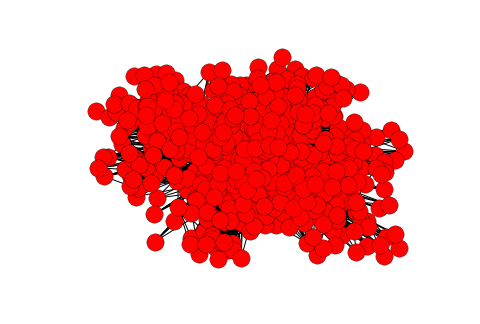

In [12]:
nx.draw(prod_graph)

#### Calculate the betweenness centrality. Using centrality, each of the tags can be ranked based on how likely they are to connect to other tags. Using this information, I can condense the >14,000 combinations down to the most central tags for each data point. Then these central tags can be used to identify the other associated tags 

In [13]:
betweenness = nx.betweenness_centrality(prod_graph)

In [14]:
bet_zip = zip(betweenness.values(),betweenness.keys())
bet_zip.sort(reverse=True)
print bet_zip[:50]

[(0.3181233337098397, u'Bekleidung'), (0.13963803571446695, u'Accessoires'), (0.050801424497208765, u'Schuhe'), (0.03644126481702051, u'W\xe4sche'), (0.02506573005160854, u'Schmuck'), (0.02222729809778493, u'Shirts'), (0.017341157438126496, u'Hosen'), (0.016717944720984486, u'Jacken'), (0.013691126836845974, u'Kleider'), (0.0118567906583459, u'T-Shirts'), (0.01152476249697074, u'Pullover'), (0.010430538112575966, u'Kurze Hosen'), (0.009279311758725256, u'Taschen'), (0.0089354808971332, u'Stiefeletten'), (0.008761060202227255, u'Blusen'), (0.00851274519283506, u'Halbschuhe'), (0.008070774838943561, u'M\xe4ntel'), (0.007997234019739695, u'Bademode'), (0.0075622249761576115, u'Sneaker'), (0.0070611600320012935, u'Halsketten'), (0.006572593267962931, u'Stiefel'), (0.006571353582718387, u'Homewear'), (0.006353140621243234, u'R\xf6cke'), (0.006137795502325252, u'Strickjacken'), (0.005680343122993081, u'Shorts'), (0.005655968261534136, u'Kost\xfcme'), (0.005542632598403195, u'Anz\xfcge'), (0.

In [15]:
group_lev = in_labels.groupby(['level'])

In [16]:
lev_dict = {}
for lev,group in group_lev:
    lev_dict[lev]=set(group['name'])

In [17]:
def get_lev_tups(product,b_list,l_dict,two_list,three_list,four_list):
    cur_list = []
    prod_list = product.split(',')
    cur_lev = 1
    for it in b_list:
        if(cur_lev<5):
            if((it[1] in l_dict[cur_lev]) and (it[1] in set(prod_list))):
                cur_list.append(it[1])
                cur_lev+=1
        else:
            break
    two_list.append(tuple(cur_list[:2]))
    three_list.append(tuple(cur_list[:3]))
    four_list.append(tuple(cur_list))

In [18]:
twos = []
threes = []
fours = []
for l in in_labelling['labels']:
    get_lev_tups(l,bet_zip,lev_dict,twos,threes,fours)

#### By picking the most central topics first, see that the number of tuples with four tags is only ~1000. These tuples uniquely identify each item in the dataset and the most commonly associated tags. Therefore the  complexity of the problem can be reduced from 1000 classes with >6 labels per datapoint to only 1000 classes with a single label per datapoint with a relatively small decrease in tagging accuracy.

In [19]:
print len(set(twos)),len(set(threes)),len(set(fours))

53 495 1174


#### Try using a large compendium of language pattern recognition tool to reduce the size of the description field, with hopes to be able to use it for features.

In [20]:
import pattern

In [21]:
from pattern.en import parsetree as en_parse
from pattern.fr import parsetree as fr_parse
from pattern.de import parsetree as de_parse
from pattern.es import parsetree as es_parse
import langdetect

In [22]:
text = 'Melanie Day and the quick brown fox jumped over the lazy dog'
test = en_parse(text,lemmata=True,tokenize=True,encoding = 'utf-8')

#### The pattern package can be used to find the nouns in a text, which are more likely to be important when trying to identify items.

In [23]:
for s in test.sentences:
    for c in s.chunks:
        for word in c.words:
            print 'NN' in word.part_of_speech,word.part_of_speech,word.string

True NNP Melanie
True NNP Day
False CC and
False DT the
False JJ quick
False JJ brown
True NN fox
False VBD jumped
False IN over
False DT the
False JJ lazy
True NN dog


In [24]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

In [25]:
def nounify(in_text):
    noun_text = ''
    bad_text = False
    in_text = in_text.decode('latin1')
    try:
        langdetect.detect(in_text)
    except:
        return noun_text
    if(langdetect.detect(in_text)=='en'):
        parsed_text = en_parse(in_text,lemmata=True,tokenize=True,encoding = 'utf-8')
    if(langdetect.detect(in_text)=='es'):
        parsed_text = es_parse(in_text,lemmata=True,tokenize=True,encoding = 'utf-8')
    elif(langdetect.detect(in_text)=='de'):
        parsed_text = de_parse(in_text,lemmata=True,tokenize=True,encoding = 'utf-8')
    elif(langdetect.detect(in_text)=='fr'):
        parsed_text = fr_parse(in_text,lemmata=True,tokenize=True,encoding = 'utf-8')
    else:
        bad_text = True
    if(not(bad_text)):
        for s in parsed_text.sentences:
            for c in s.chunks:
                for word in c.words:
                    if('NN' in word.part_of_speech):
                        noun_text+=word.string+' '  
    return noun_text

#### In testing the algorithm, it is clear that it works best for english, and misidentifies some words as nouns in other languages. Finding software that can identify parts of speech in multiple languages is very difficult

In [26]:
en_nouns = nounify(text)

In [27]:
en_nouns

''

In [28]:
fr_text = 'Melanie Day et Le vif renard brun saute par dessus le chien paresseux'

In [29]:
fr_nouns = nounify(fr_text)

In [30]:
fr_nouns

u'Melanie Day renard brun chien paresseux '

In [31]:
de_text = 'Zwölf Boxkämpfer jagen Viktor quer über den großen Sylter Deich'.encode('utf-8')

In [32]:
de_text

'Zw\xc3\xb6lf Boxk\xc3\xa4mpfer jagen Viktor quer \xc3\xbcber den gro\xc3\x9fen Sylter Deich'

In [33]:
de_nouns = nounify(de_text)

In [34]:
de_nouns

u'Boxk\xc3\xa4mpfer Viktor quer \xc3\xbcber gro\xc3\x9fen Sylter Deich '

#### Find that processing the text takes extremely long on my laptop. I implemented the below code in a separate python file (multiprocessing cannot be run inside of a jupyter notebook). However, even with multiprocessing filtering the text still takes >6 hours, and given my time constraints I had to give up on it.

In [40]:
import multiprocessing
pool = multiprocessing.Pool(8)

In [41]:
def noun_apply(df):
    res = df.apply(nounify)
    return res

In [ ]:
name_results = pool.map(noun_apply, numpy.array_split(in_labelling['name'],8))

In [ ]:
name_results.head()

In [ ]:
pool.close()
pool.join()